In [1]:
import matplotlib
matplotlib.use("nbagg")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import dlc_bci as bci
from utility import * 

## Get Data
Fetches the data from the server and saves it to a folder at the root 

In [3]:
train_input, train_target, test_input, test_target = import100HzData()
train_input_1000, train_target_1000, test_input_1000, test_target_1000 = import1000HzData()

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])
<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [4]:
print(train_input.shape) 
print(train_target.shape) 
print(test_input.shape) 
print(test_target.shape) 

torch.Size([316, 28, 50])
torch.Size([316])
torch.Size([100, 28, 50])
torch.Size([100])


## Visualize the data

In [5]:
#rawDataForSingleElectrodeVisualization(train_input)

# Preprocessing

Noise removed - Trend Removed - Offset translated - Normalized 

### A "0" Labelled signal - Without Preprocessing

<IPython.core.display.Javascript object>


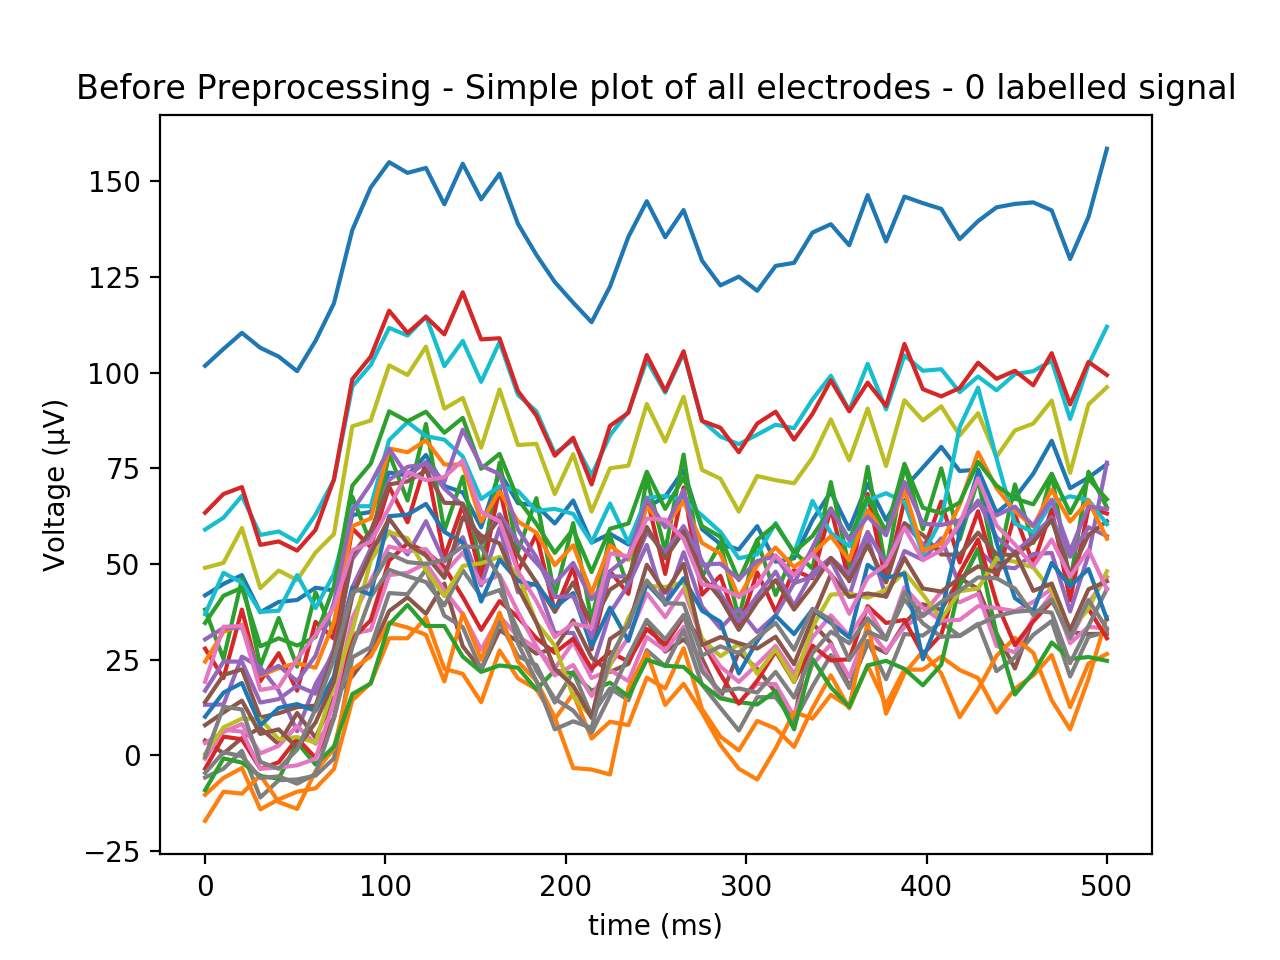

<IPython.core.display.Javascript object>


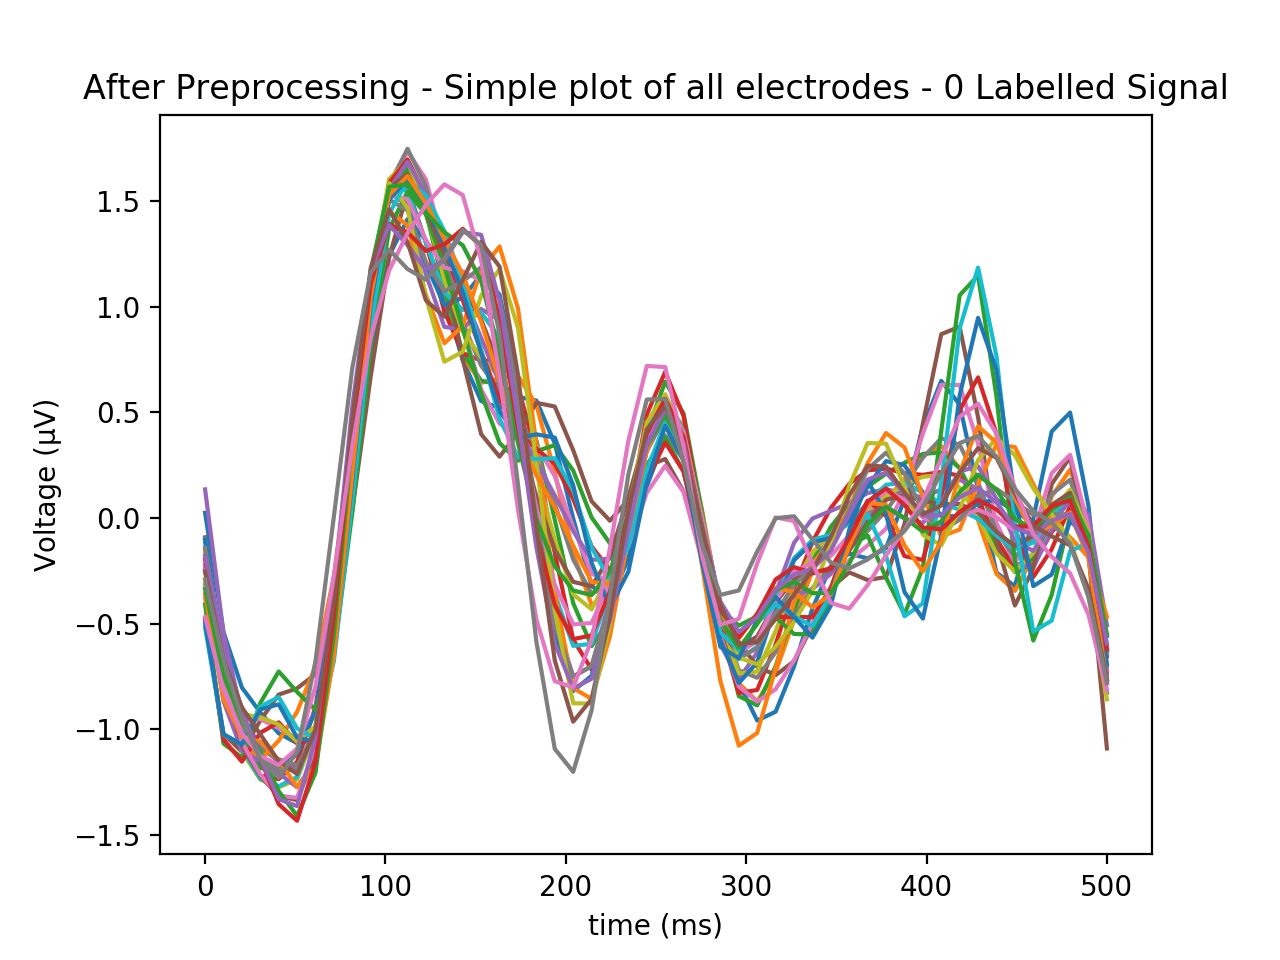

In [6]:
time = np.linspace(0, 500, 50)

rawDataVisualization(train_input, 0, 'Before Preprocessing - Simple plot of all electrodes - 0 labelled signal')
normalizedSingleSignals(train_input, time, 0, True, 'After Preprocessing - Simple plot of all electrodes - 0 Labelled Signal'); 

### A "1" Labelled signal 

<IPython.core.display.Javascript object>


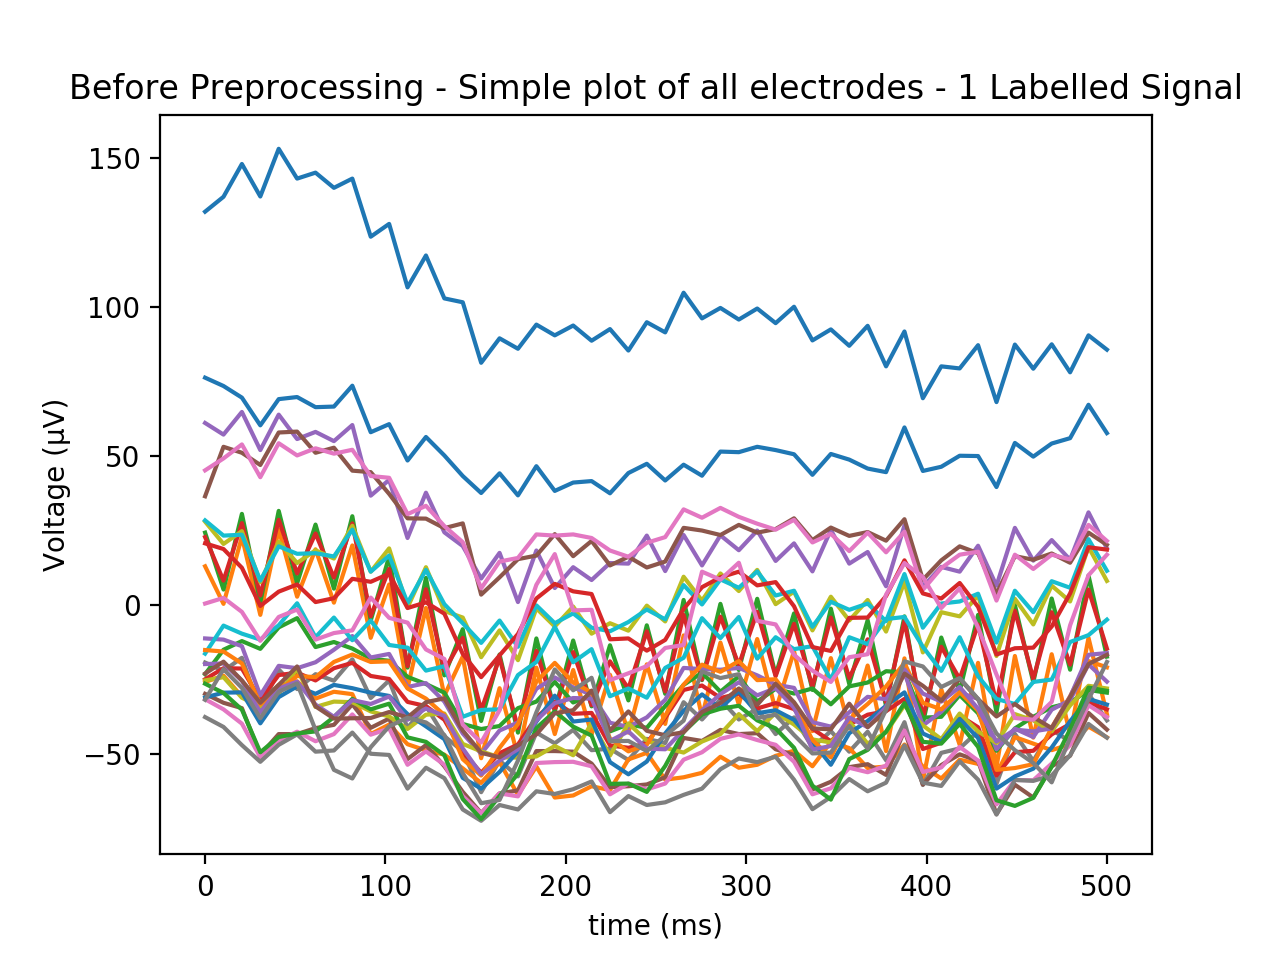

<IPython.core.display.Javascript object>


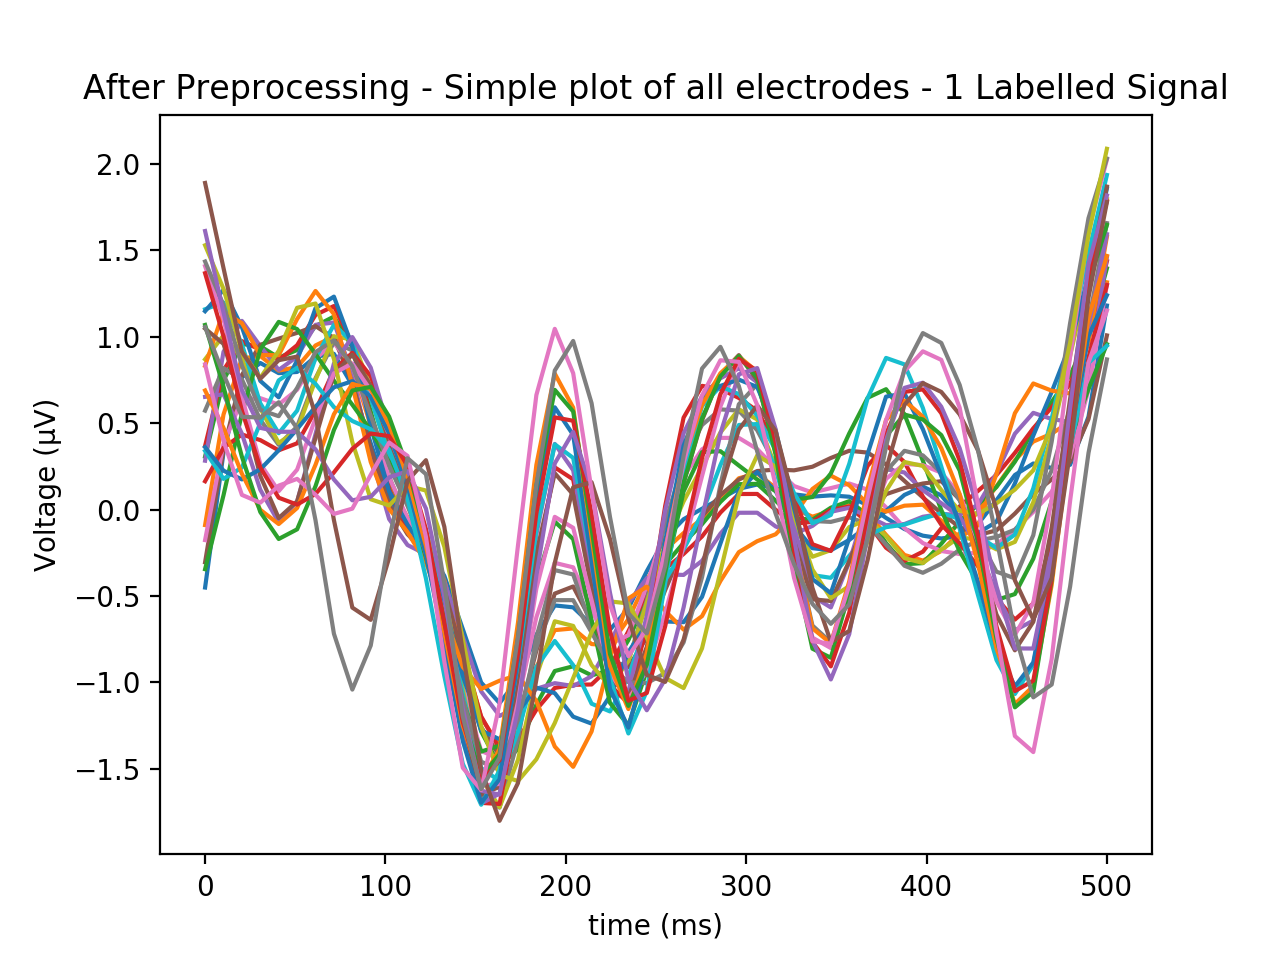

In [7]:
time = np.linspace(0, 500, 50)

rawDataVisualization(train_input, 1, 'Before Preprocessing - Simple plot of all electrodes - 1 Labelled Signal')
normalizedSingleSignals(train_input, time, 1, True, 'After Preprocessing - Simple plot of all electrodes - 1 Labelled Signal');

# Visualize some Normalized signals 

<IPython.core.display.Javascript object>


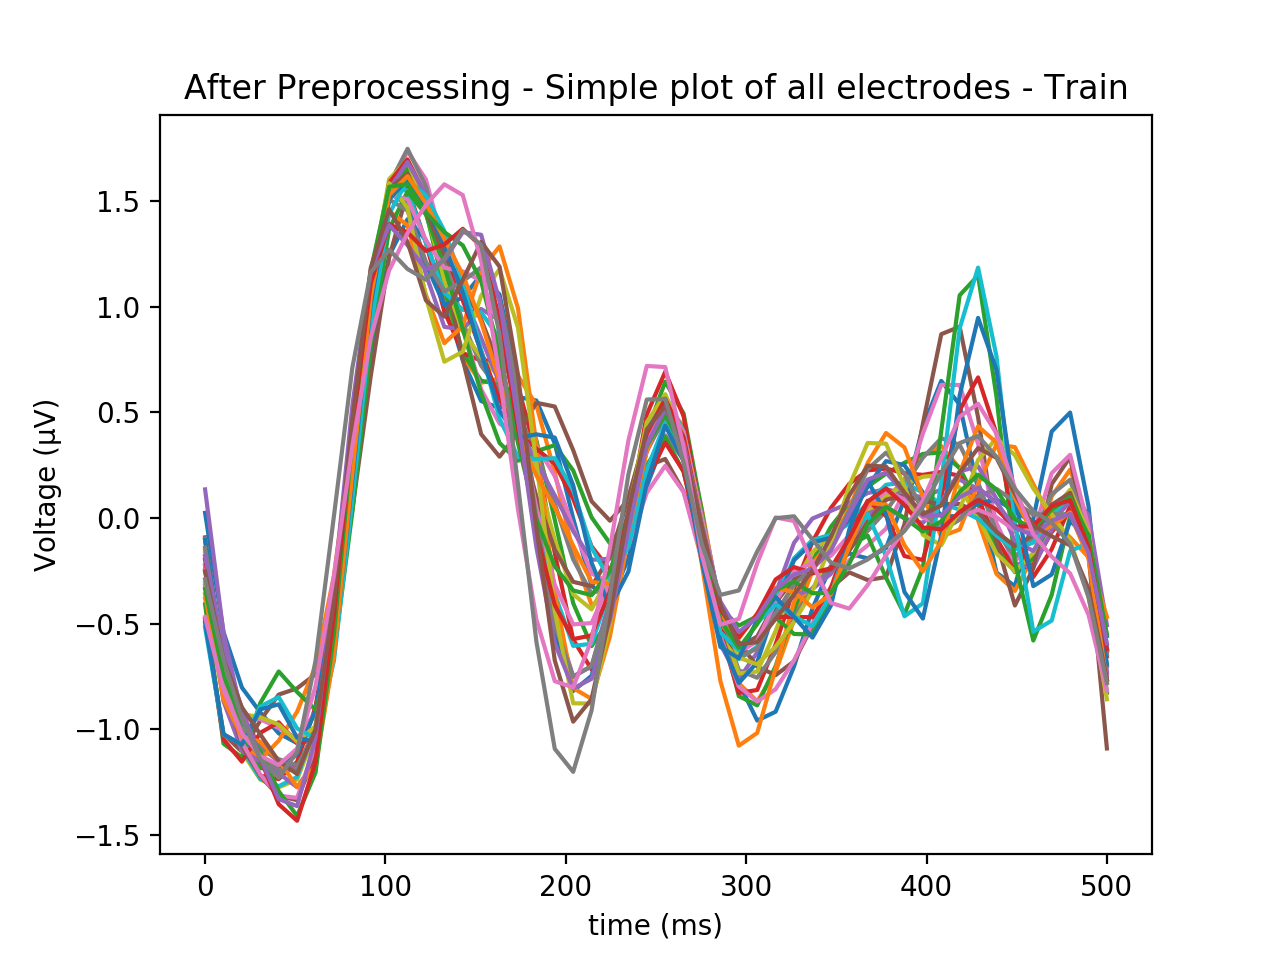

<IPython.core.display.Javascript object>


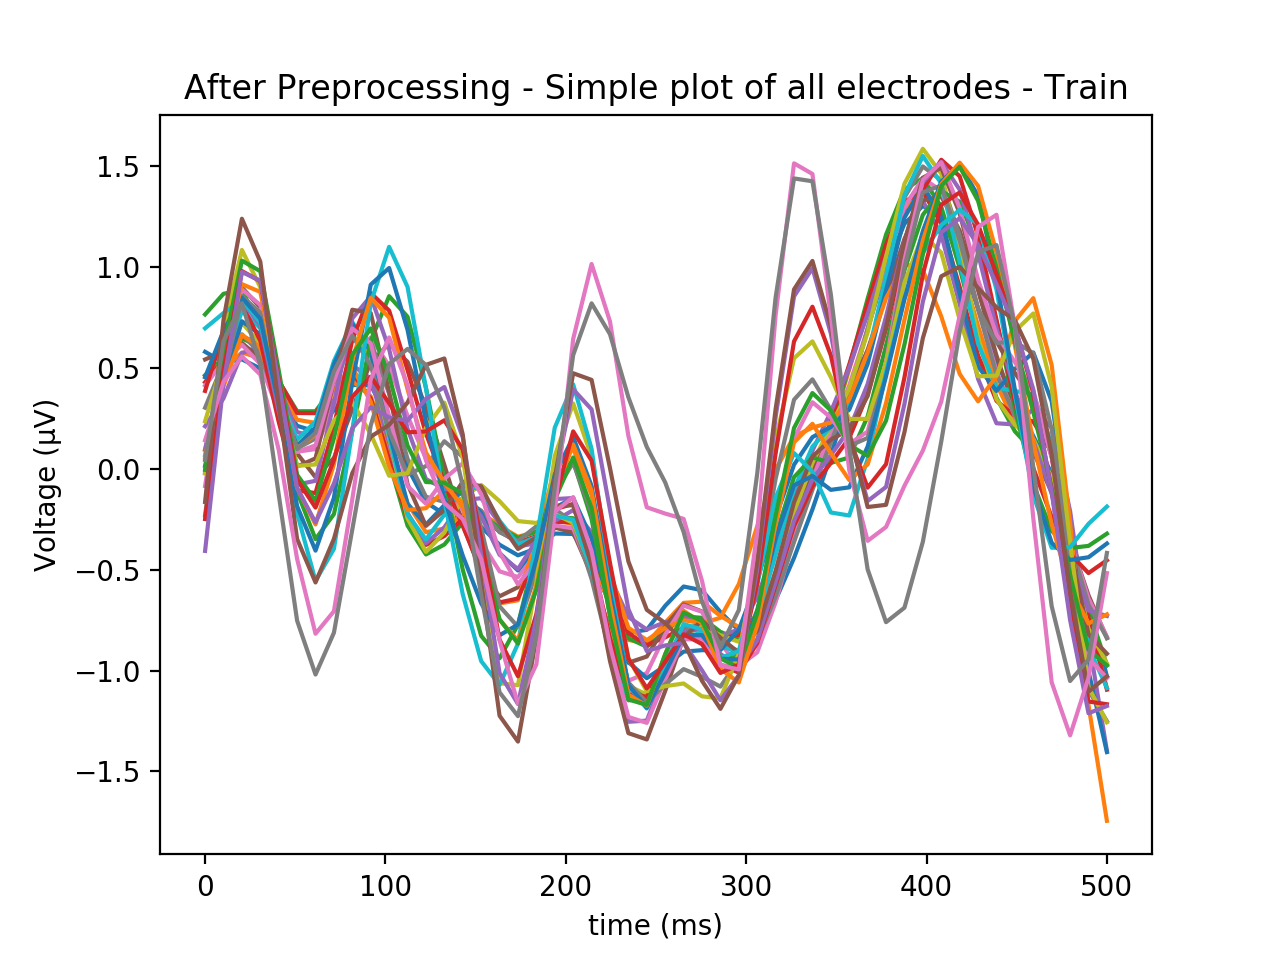

<IPython.core.display.Javascript object>


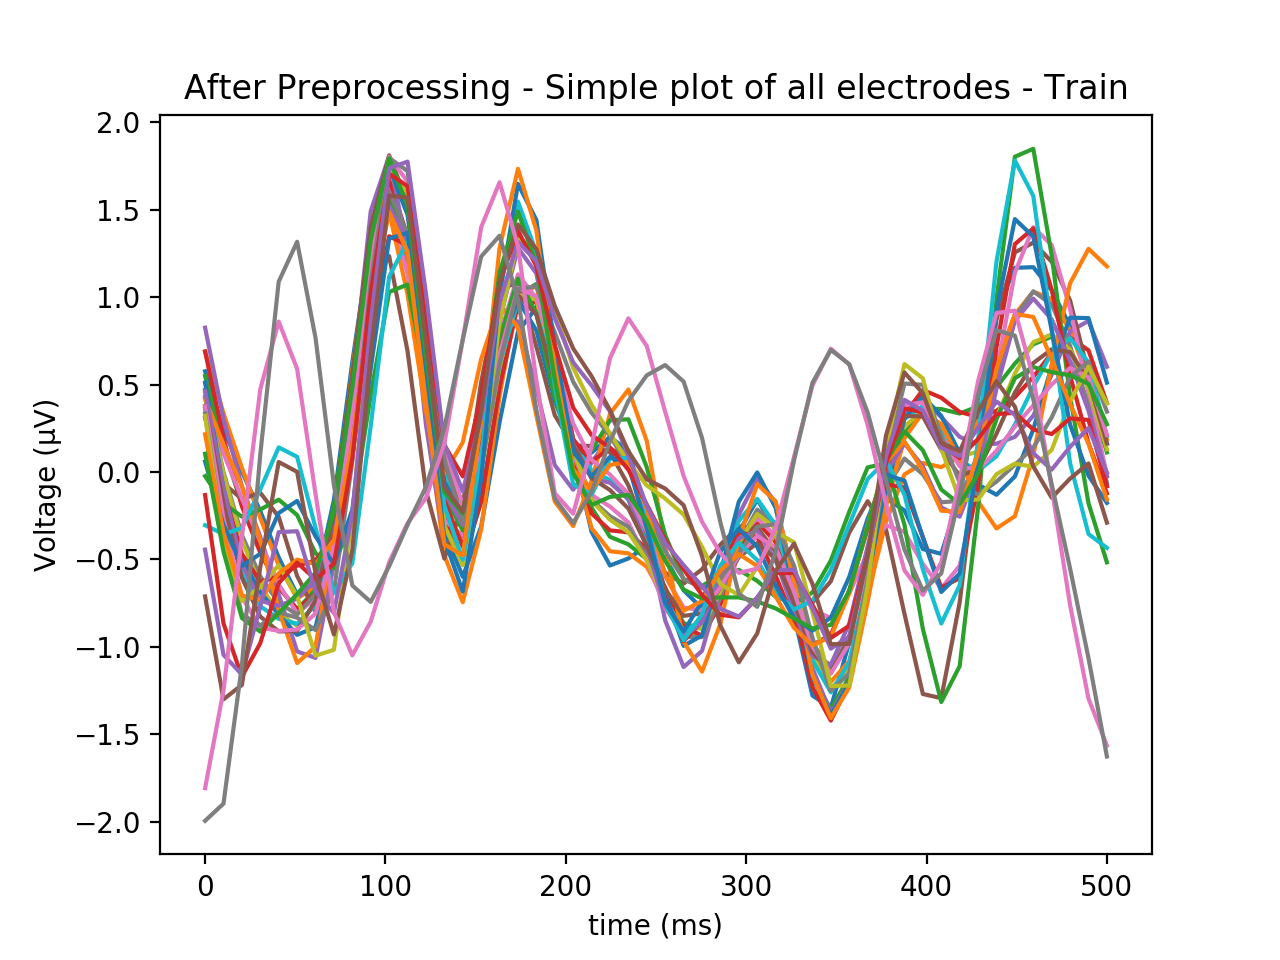

<IPython.core.display.Javascript object>


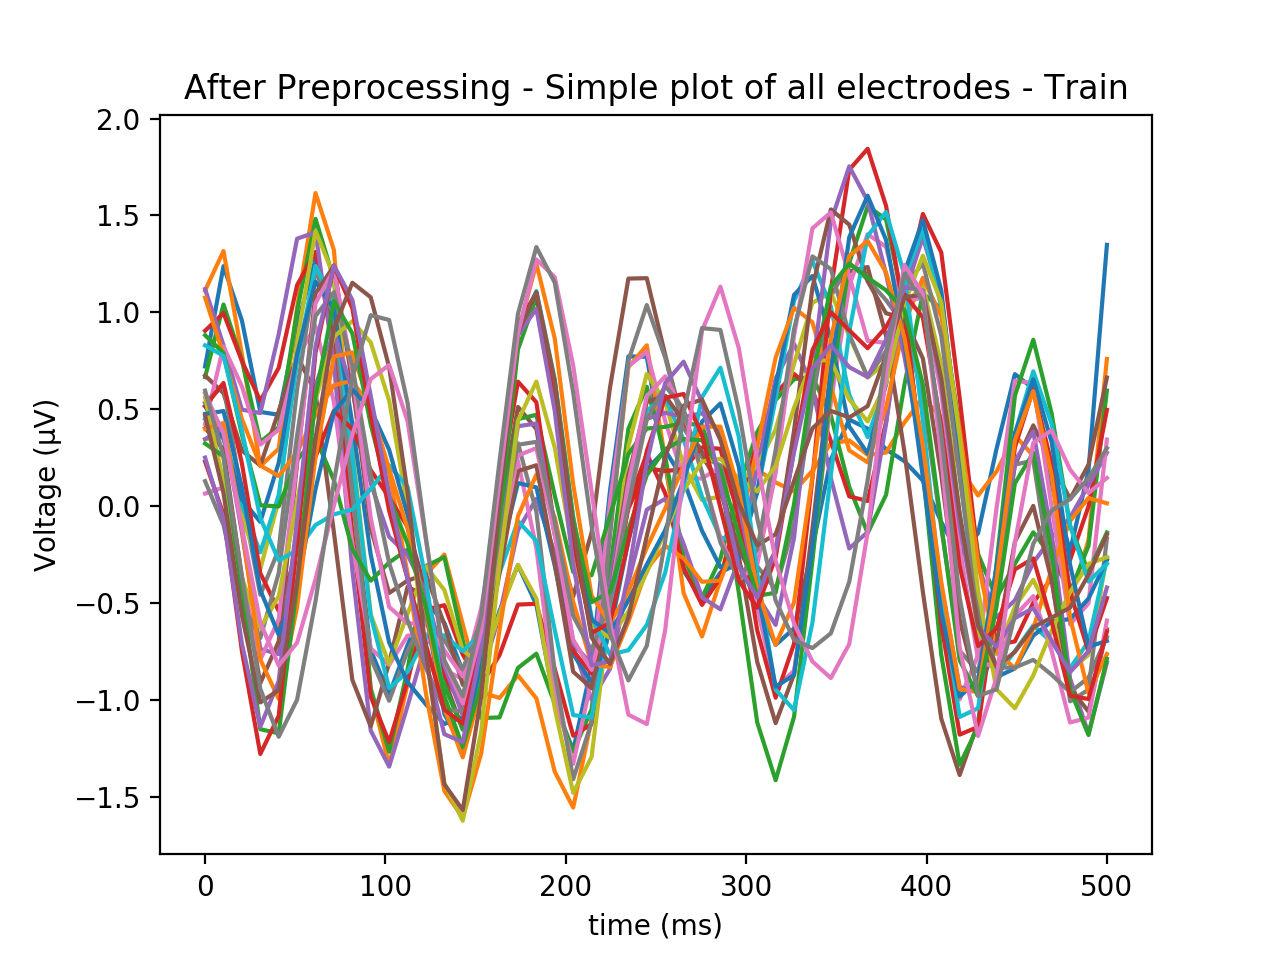

In [8]:
time = np.linspace(0, 500, 50)
normalized_input_train = normalizedSignals(train_input, time, True, 'After Preprocessing - Simple plot of all electrodes - Train')

<IPython.core.display.Javascript object>


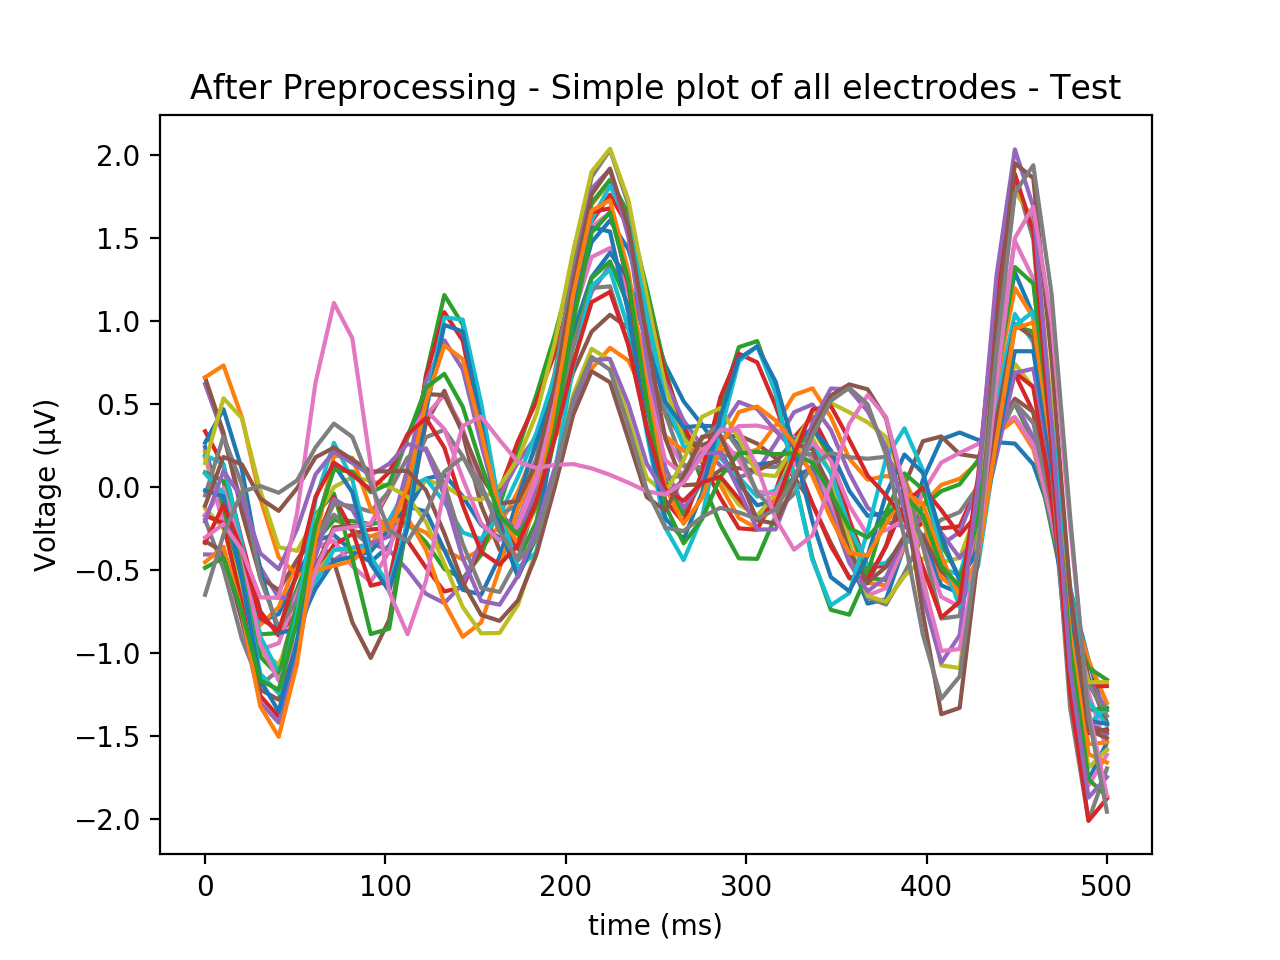

<IPython.core.display.Javascript object>


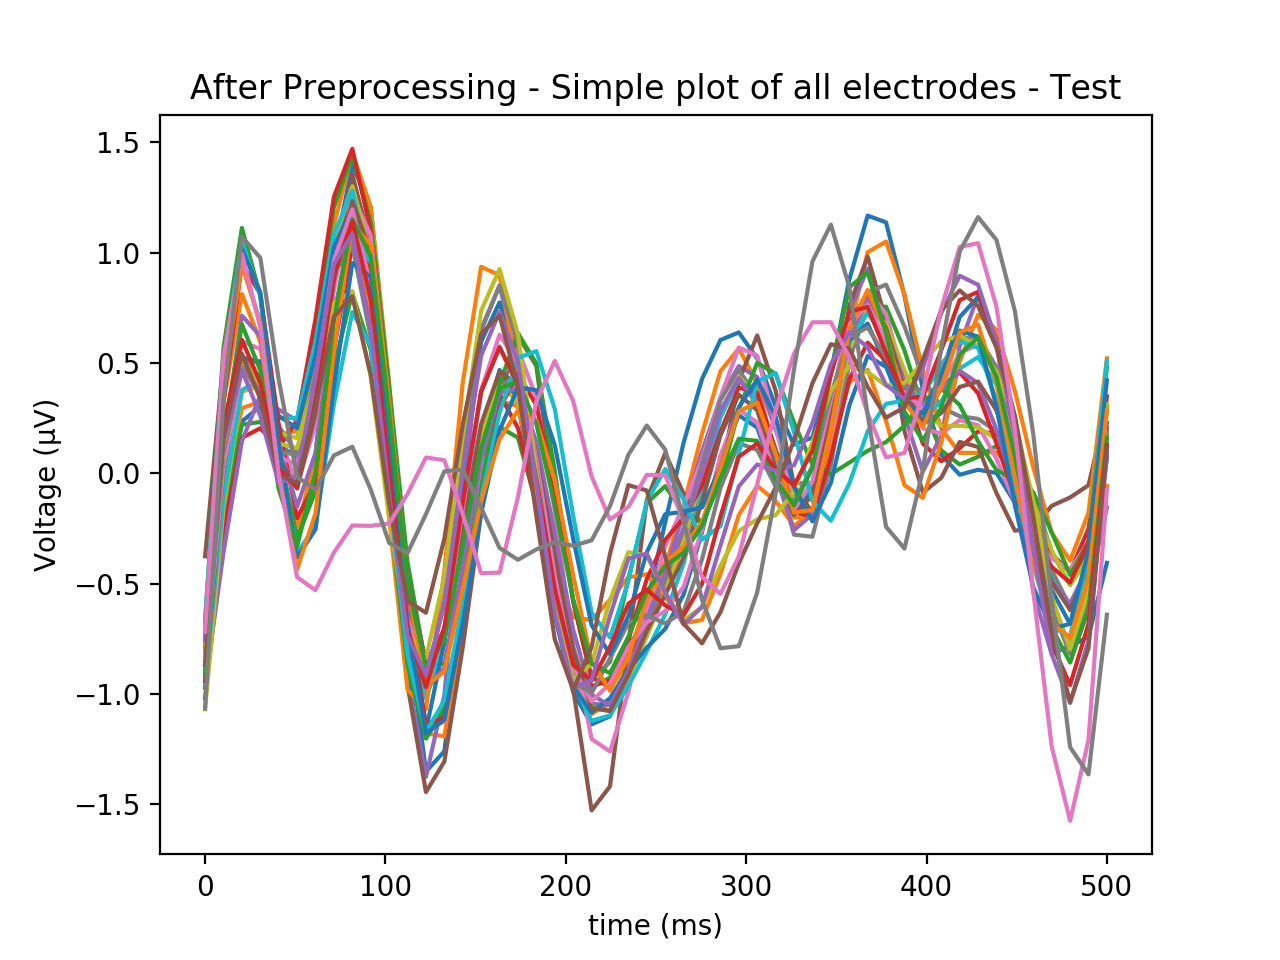

In [9]:
normalized_input_test = normalizedSignals(test_input, time, True, 'After Preprocessing - Simple plot of all electrodes - Test')

# Neural Net

Copy the neural network from the Neural Networks section before and modify it to take 18-channel signal (instead of 1-channel images as it was defined).

2. Define a Convolution Neural Network

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Initialize all the possible treatments that we can apply to the incoming signal
        self.conv1 = nn.Conv1d(28, 56, 3) #nn.Conv2d(nbChannels_in, outputChannels, kxk Square convolution)
        self.batchnorm1 = nn.BatchNorm1d(56, False)
        
        self.conv2 = nn.Conv1d(56, 112, 3) #nn.Conv2d(nbChannels_in, outputChannels, kxk Square convolution)
        self.batchnorm2 = nn.BatchNorm1d(112, False)
        
        self.pool = nn.MaxPool1d(5)
        self.dp = nn.Dropout(p=0.25)
        
        self.conv4 = nn.Conv1d(112, 52, 3)
        self.batchnorm4 = nn.BatchNorm1d(52, False)
        
        self.conv5 = nn.Conv1d(52, 6, 3)
        self.batchnorm5 = nn.BatchNorm1d(6, False)


        self.fc1 = nn.Linear(6 * 42, 120)
        self.fc2 = nn.Linear(120, 30)
        self.fc3 = nn.Linear(30, 2) #2 output channel one for the left direction and one for the rightweb

    def forward(self, x):
        print('Initial Shape: ', x.shape)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        print('First conv1d: ', x.shape)
        x = self.dp(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        print('Second conv1d: ',x.shape)
        
        x = self.dp(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        print('Second conv1d: ',x.shape)
        
        x = self.dp(x)
        x = self.conv5(x)
        x = self.batchnorm5(x)
        print('Second conv1d: ',x.shape)
        
        x = x.view(-1, 6 * 42) #get the right shape of the output this has to be of the shape of self.fc1
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.relu(self.fc2(x))
        print(x.shape)
        x = self.fc3(x)
        return x

net = Net()

3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

NameError: name 'nn' is not defined

4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
x1, x2, x3, x4 = cross_validation(np.array(train_input))
y1, y2, y3, y4 = cross_validation_labels(np.array(train_target))
x = [x1, x2, x3, x4]
y = [y1, y2, y3, y4]

for i in range (0,4):    
    for epoch in range(75):  # loop over the dataset multiple times
        print ("\nEpoch ", epoch)
        running_loss = 0.0

        #inputs = torch.from_numpy(normalized_input_train).float()
        #inputs = train_input #x_train
        inputs = torch.from_numpy(x[i]).float()
        #inputs = torch.unsqueeze(inputs,1) # make it float and insert a fake batch dimension
        #labels = train_target #y_train
        labels = torch.from_numpy(y[i]) #y_train

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.data[0]
        print("Running loss", running_loss)

        # Validation accuracy
        params = ["acc", "auc", "fmeasure"]

5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

# Test Dataset - Prediction 

In [ ]:
correct = 0
total = 0

#prediction = torch.from_numpy(normalized_input_test).float() #With normalized input 
prediction = test_input #x_train
#prediction_squeezed = torch.unsqueeze(prediction,1) # make it float and insert a fake batch dimension [316x1x28x50] to make 2D convolutions
labels = test_target #y_train

# wrap them in Variable
predictionVar, labelsVar = Variable(prediction), Variable(labels)
#predictionVar, labelsVar = Variable(prediction_squeezed), Variable(labels)



# forward + backward + optimize
#The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks
#that the image is of the particular class. So, let’s get the index of the highest energy:
outputsPred = net(predictionVar) 

_, predicted = torch.max(outputsPred.data, 1) #predicted contains the predicted labels
total += labels.size(0)
correct += (predicted == labels).sum()

print('Accuracy of the network on the test singals: %d %%' % (100 * correct / total))

# Test some Already implemented NN 

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(28, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x
